# Objective:

Comparing DNN and LEAR ensemble models as a benchmark and LSTM model using same sets of Train and Test datas. 

In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
from scipy import stats
import datetime
import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM,Dropout
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Import Libraries for reading data
import epftoolbox
from epftoolbox.data import read_data
from epftoolbox.data import DataScaler

In [4]:
# Import Libraries for Model Evaluation
from epftoolbox.evaluation import MAE 
from epftoolbox.evaluation import RMSE 
from epftoolbox.evaluation import MAPE
from epftoolbox.evaluation import sMAPE
from epftoolbox.evaluation import MASE
from epftoolbox.evaluation import rMAE


# LSTM Model for DE

In [5]:
# Load data into dataframe
df_train, df_test = read_data(path='.', dataset='DE', begin_test_date='04/01/2016', end_test_date='31/12/2017')
df_train.index = pd.to_datetime(df_train.index)
df_test.index = pd.to_datetime(df_test.index)

Test datasets: 2016-01-04 00:00:00 - 2017-12-31 23:00:00


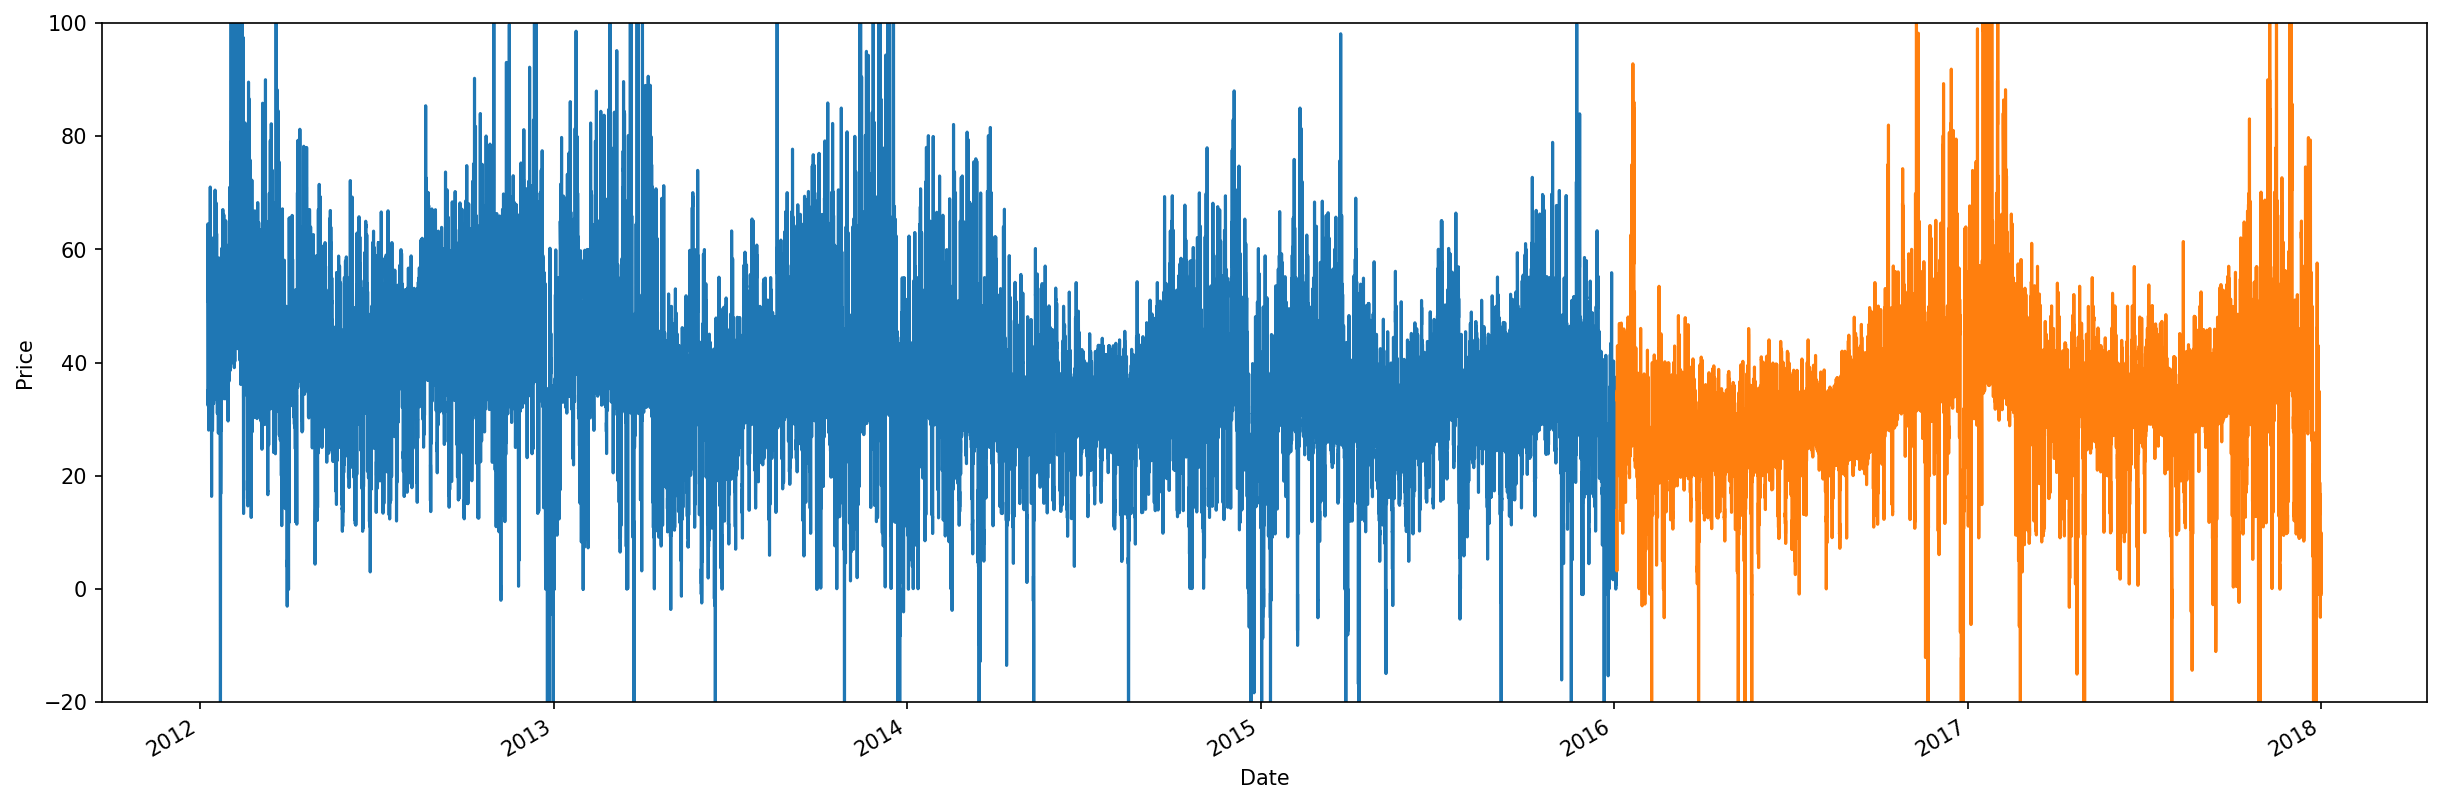

In [6]:
import matplotlib.pyplot as plt

# ploting Train (Blue) and Test (Orange) data

plt.figure(figsize=(20,6) ,dpi=150)

plt.plot(df_train.Price)
plt.plot(df_test.Price)
plt.ylim(-20, 100)
plt.xticks(rotation=30, ha='right')
plt.xlabel('Date')
plt.ylabel('Price')
plt.savefig('DE.png')

In [7]:
# Creating Train and Test Data
Xtrain = df_train.iloc[:, [0]]
Xtest = df_test.iloc[:, [0]]

In [8]:
# Function to create data for LSTM
def create_lstm_data(data, look_back):
    X, y = [], []
    for i in range(look_back, len(data)):
        X.append(data[i-look_back:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

In [9]:
Xtest.index.names = ['Date']

In [10]:
Xtrain.head()
Xtrain.index.names = ['Date']
Xtrain.head()

,Price
Date,
2012-01-09 00:00:00,34.97
2012-01-09 01:00:00,33.43
2012-01-09 02:00:00,32.74
2012-01-09 03:00:00,32.46
2012-01-09 04:00:00,32.50


In [11]:
# Create LSTM model for 48 LookBack

predict = 24
look_back = 24

# Creating Train and Test Data
Xtrain = df_train.iloc[:, [0]]
Xtest = df_test.iloc[:, [0]]

#Dimensions of Train and Test Data
print('Train Dimension : ', Xtrain.shape)
print('Test Dimension : ', Xtest.shape)

# Scalar Transformation of both train and test data
scaler = DataScaler('Norm')
Xtrain_scaled = scaler.fit_transform(Xtrain)
Xtest_scaled = scaler.fit_transform(Xtest.loc[:])

# Create data for LSTM
train_X, train_y = create_lstm_data(Xtrain_scaled, look_back)
# Reshape data for LSTM
train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1))

Train Dimension :  (34944, 1)
Test Dimension :  (17472, 1)


In [12]:
# Create LSTM Model
#Start Time
st_24 = time.time()

model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(look_back, 1)))
model.add(LSTM(32, return_sequences=False))
model.add(Dense(1, activation='linear'))

model.compile(loss='mean_squared_error', optimizer='adam')

#fit the model
model.fit(train_X, train_y, epochs=12, batch_size=64, validation_split=0.1, verbose=1)

#End time 
et_24 = time.time()

Epoch 1/12
492/492 [==============================] - 24s 43ms/step - loss: 0.0044 - val_loss: 8.2300e-04
Epoch 2/12
492/492 [==============================] - 16s 33ms/step - loss: 8.9438e-04 - val_loss: 5.6244e-04
Epoch 3/12
492/492 [==============================] - 19s 39ms/step - loss: 8.1391e-04 - val_loss: 6.5462e-04
Epoch 4/12
492/492 [==============================] - 16s 32ms/step - loss: 6.1648e-04 - val_loss: 3.4481e-04
Epoch 5/12
492/492 [==============================] - 16s 32ms/step - loss: 3.9490e-04 - val_loss: 1.7851e-04
Epoch 6/12
492/492 [==============================] - 16s 33ms/step - loss: 2.6375e-04 - val_loss: 1.6219e-04
Epoch 7/12
492/492 [==============================] - 16s 33ms/step - loss: 2.1944e-04 - val_loss: 3.0425e-04
Epoch 8/12
492/492 [==============================] - 16s 32ms/step - loss: 2.0319e-04 - val_loss: 1.2885e-04
Epoch 9/12
492/492 [==============================] - 17s 34ms/step - loss: 1.9289e-04 - val_loss: 9.1558e-05
Epoch 10/12
49

In [13]:
# predicting price for 24 hr time period 
Xtest_data = Xtest_scaled.reshape(1,Xtest_scaled.shape[0],1)
predicted_values_24 = []

for h in range(0,int(len(Xtest)-predict-look_back)):
    input_data = Xtest_data[:,h:h+look_back,:]
    output_data = model.predict(input_data)
    predicted_values_24.append(output_data)
    
#Creating List for output
Output_24 = [elem for twod in predicted_values_24 for elem in twod]
predicted_values_24 = scaler.inverse_transform(Output_24)

#Creating Data for Observed and Predicted Values 
res = pd.DataFrame(Xtest[look_back+predict:], index = Xtest.index[look_back+predict:])


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 24ms/step


In [14]:
res['Predicted_24'] = predicted_values_24

In [15]:
# Create LSTM model for 48 LookBack

predict = 24
look_back = 48

# Creating Train and Test Data
Xtrain = df_train.iloc[:, [0]]
Xtest = df_test.iloc[:, [0]]

#Dimensions of Train and Test Data
print('Train Dimension : ', Xtrain.shape)
print('Test Dimension : ', Xtest.shape)

# Scalar Transformation of both train and test data
scaler = DataScaler('Norm')
Xtrain_scaled = scaler.fit_transform(Xtrain)
Xtest_scaled = scaler.fit_transform(Xtest.loc[:])

# Create data for LSTM
train_X, train_y = create_lstm_data(Xtrain_scaled, look_back)
# Reshape data for LSTM
train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1))

Train Dimension :  (34944, 1)
Test Dimension :  (17472, 1)


In [16]:
# Create LSTM Model
#Start Time
st_48 = time.time()

model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(look_back, 1)))
model.add(LSTM(32, return_sequences=False))
model.add(Dense(1, activation='linear'))

model.compile(loss='mean_squared_error', optimizer='adam')

#fit the model
model.fit(train_X, train_y, epochs=12, batch_size=64, validation_split=0.1, verbose=1)

#End time 
et_48 = time.time()

Epoch 1/12
491/491 [==============================] - 30s 56ms/step - loss: 0.0055 - val_loss: 6.3592e-04
Epoch 2/12
491/491 [==============================] - 35s 71ms/step - loss: 9.3380e-04 - val_loss: 6.0998e-04
Epoch 3/12
491/491 [==============================] - 36s 72ms/step - loss: 8.3791e-04 - val_loss: 5.5888e-04
Epoch 4/12
491/491 [==============================] - 34s 69ms/step - loss: 6.5671e-04 - val_loss: 3.7170e-04
Epoch 5/12
491/491 [==============================] - 30s 62ms/step - loss: 4.9502e-04 - val_loss: 2.4607e-04
Epoch 6/12
491/491 [==============================] - 30s 61ms/step - loss: 3.4439e-04 - val_loss: 1.5881e-04
Epoch 7/12
491/491 [==============================] - 30s 62ms/step - loss: 2.5291e-04 - val_loss: 1.7696e-04
Epoch 8/12
491/491 [==============================] - 31s 62ms/step - loss: 2.1916e-04 - val_loss: 2.3989e-04
Epoch 9/12
491/491 [==============================] - 31s 63ms/step - loss: 1.9359e-04 - val_loss: 9.2274e-05
Epoch 10/12
49

In [17]:
# predicting price for 24 hr time period 
Xtest_data = Xtest_scaled.reshape(1,Xtest_scaled.shape[0],1)
predicted_values_48 = []

for h in range(0,int(len(Xtest)-predict-look_back)):
    input_data = Xtest_data[:,h:h+look_back,:]
    output_data = model.predict(input_data)
    predicted_values_48.append(output_data)
    
#Creating List for output
Output_48 = [elem for twod in predicted_values_48 for elem in twod]
predicted_values_48 = scaler.inverse_transform(Output_48)



1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 46ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 54ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 21ms/step


In [18]:
#Creating Data for Observed and Predicted Values 
end = [0]*24
pred48 = np.append(predicted_values_48,end)
res['Predicted_48'] = pred48

In [19]:
# Create LSTM model for 240 LookBack

predict = 24
look_back = 96

# Creating Train and Test Data
Xtrain = df_train.iloc[:, [0]]
Xtest = df_test.iloc[:, [0]]

#Dimensions of Train and Test Data
print('Train Dimension : ', Xtrain.shape)
print('Test Dimension : ', Xtest.shape)

# Scalar Transformation of both train and test data
scaler = DataScaler('Norm')
Xtrain_scaled = scaler.fit_transform(Xtrain)
Xtest_scaled = scaler.fit_transform(Xtest.loc[:])

# Create data for LSTM
train_X, train_y = create_lstm_data(Xtrain_scaled, look_back)
# Reshape data for LSTM
train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1))

Train Dimension :  (34944, 1)
Test Dimension :  (17472, 1)


In [20]:
# Create LSTM Model
#Start Time
st_96 = time.time()

model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(look_back, 1)))
model.add(LSTM(32, return_sequences=False))
model.add(Dense(1, activation='linear'))

model.compile(loss='mean_squared_error', optimizer='adam')

#fit the model
model.fit(train_X, train_y, epochs=12, batch_size=64, validation_split=0.1, verbose=1)

#End time 
et_96 = time.time()

Epoch 1/12
491/491 [==============================] - 60s 117ms/step - loss: 0.0058 - val_loss: 6.4678e-04
Epoch 2/12
491/491 [==============================] - 57s 116ms/step - loss: 9.0857e-04 - val_loss: 5.8375e-04
Epoch 3/12
491/491 [==============================] - 57s 116ms/step - loss: 8.4478e-04 - val_loss: 5.7623e-04
Epoch 4/12
491/491 [==============================] - 57s 116ms/step - loss: 7.5117e-04 - val_loss: 4.3823e-04
Epoch 5/12
491/491 [==============================] - 57s 116ms/step - loss: 6.0612e-04 - val_loss: 3.1594e-04
Epoch 6/12
491/491 [==============================] - 57s 116ms/step - loss: 4.3180e-04 - val_loss: 2.8741e-04
Epoch 7/12
491/491 [==============================] - 57s 117ms/step - loss: 2.9037e-04 - val_loss: 1.7124e-04
Epoch 8/12
491/491 [==============================] - 57s 117ms/step - loss: 2.2687e-04 - val_loss: 1.3248e-04
Epoch 9/12
491/491 [==============================] - 58s 117ms/step - loss: 2.0788e-04 - val_loss: 2.4651e-04
Epoch

In [21]:
# predicting price for 24 hr time period 
Xtest_data = Xtest_scaled.reshape(1,Xtest_scaled.shape[0],1)
predicted_values_96 = []

for h in range(0,int(len(Xtest)-predict-look_back)):
    input_data = Xtest_data[:,h:h+look_back,:]
    output_data = model.predict(input_data)
    predicted_values_96.append(output_data)
    
#Creating List for output
Output_96 = [elem for twod in predicted_values_96 for elem in twod]
predicted_values_96 = scaler.inverse_transform(Output_96)



1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 72ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 17ms/step


In [22]:
#Creating Data for Observed and Predicted Values 
end = [0]*72
pred96 = np.append(predicted_values_96,end)
res['Predicted_96'] = pred96

In [23]:
res.head(10)

,Price,Predicted_24,Predicted_48,Predicted_96
Date,,,,
2016-01-06 00:00:00,26.62,20.171808,25.920448,24.562443
2016-01-06 01:00:00,25.58,22.861130,26.996993,12.961839
2016-01-06 02:00:00,24.59,22.760030,27.119934,21.159467
2016-01-06 03:00:00,22.50,20.927550,27.208067,17.850679
2016-01-06 04:00:00,23.16,20.677415,25.825316,16.571802
2016-01-06 05:00:00,24.99,19.623464,27.408448,18.066915
2016-01-06 06:00:00,26.62,24.277395,29.862405,22.457131
2016-01-06 07:00:00,28.03,30.166197,31.644396,27.259711
2016-01-06 08:00:00,29.34,39.574599,32.830704,32.927604


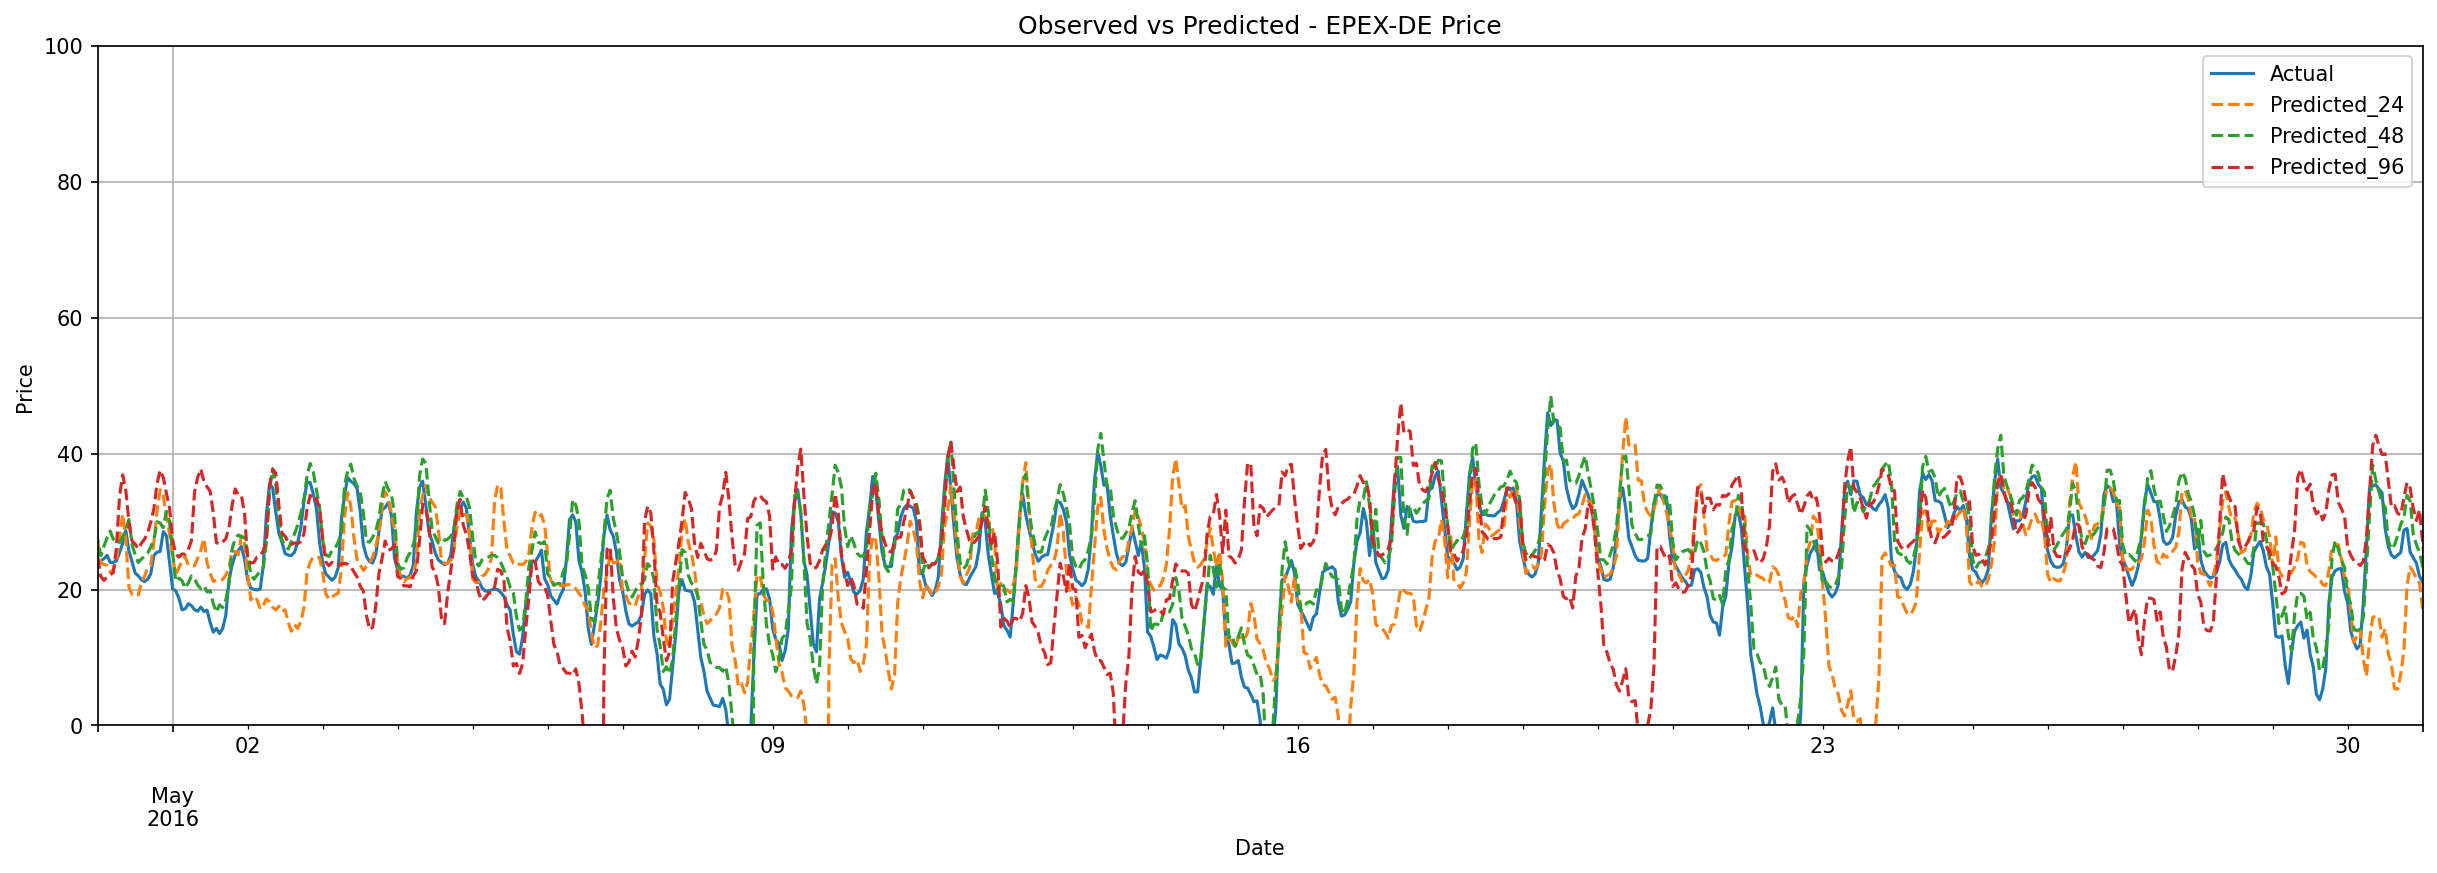

In [24]:
# ploting Observed and predicted values for 4 days 
plt.figure(figsize=(20,6) ,dpi=150)

ax1 = res.Price.plot(grid=True, label='Actual')
ax2 = res.Predicted_24.plot(grid=True, label='Predicted_24',linestyle='--')
ax3 = res.Predicted_48.plot(grid=True, label='Predicted_48',linestyle='--')
ax4 = res.Predicted_96.plot(grid=True, label='Predicted_96',linestyle='--')


ax1.set_ylim(0, 100)
ax2.set_ylim(0, 100)
ax3.set_ylim(0, 100)
ax4.set_ylim(0, 100)

plt.title('Observed vs Predicted - EPEX-DE Price')
plt.xlim([datetime.date(2016,4,30), datetime.date(2016, 5, 31)])
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc ="best")
plt.savefig('NP_P.png')
plt.show()

In [25]:
# Model Evaluation for LSTM for 24
MAE_l_24 = MAE(p_pred=res.Predicted_24, p_real=res.Price)
RMSE_l_24 = RMSE(p_pred=res.Predicted_24, p_real=res.Price)
MAPE_l_24 = MAPE(p_pred=res.Predicted_24, p_real=res.Price) * 100
sMAPE_l_24 = sMAPE(p_pred=res.Predicted_24, p_real=res.Price) * 100
MASE_l_24 = MASE(p_pred=res.Predicted_24, p_real=res.Price, p_real_in=res.Price, m='W')
rMAE_l_24 = rMAE(p_pred=res.Predicted_24, p_real=res.Price)

In [26]:
# Model Evaluation for LSTM for 48
MAE_l_48 = MAE(p_pred=res.Predicted_48, p_real=res.Price)
RMSE_l_48 = RMSE(p_pred=res.Predicted_48, p_real=res.Price)
MAPE_l_48 = MAPE(p_pred=res.Predicted_48, p_real=res.Price) * 100
sMAPE_l_48 = sMAPE(p_pred=res.Predicted_48, p_real=res.Price) * 100
MASE_l_48 = MASE(p_pred=res.Predicted_48, p_real=res.Price, p_real_in=res.Price, m='W')
rMAE_l_48 = rMAE(p_pred=res.Predicted_48, p_real=res.Price)

In [27]:
# Model Evaluation for LSTM for 96
MAE_l_96 = MAE(p_pred=res.Predicted_96, p_real=res.Price)
RMSE_l_96 = RMSE(p_pred=res.Predicted_96, p_real=res.Price)
MAPE_l_96 = MAPE(p_pred=res.Predicted_96, p_real=res.Price) * 100
sMAPE_l_96 = sMAPE(p_pred=res.Predicted_96, p_real=res.Price) * 100
MASE_l_96 = MASE(p_pred=res.Predicted_96, p_real=res.Price, p_real_in=res.Price, m='W')
rMAE_l_96 = rMAE(p_pred=res.Predicted_96, p_real=res.Price)

# DNN ensemble Model for DE Market

In [28]:
# Read the predicted datas using benchmark models in the paper 
forecast = pd.read_csv('https://raw.githubusercontent.com/jeslago/epftoolbox/master/' +
                     'forecasts/Forecasts_DE_DNN_LEAR_ensembles.csv', index_col=0)
# Transforming indices to datetime format
forecast.index = pd.to_datetime(forecast.index)
# Reading data from the NP market
df_train, df_test = read_data(path='.', dataset='DE', begin_test_date=forecast.index[0],
                        end_test_date=forecast.index[-1])
#predicted price
fc_DNN_ensemble = forecast.loc[:, ['DNN Ensemble']]
fc_LEAR_ensemble = forecast.loc[:, ['LEAR Ensemble']]
#Real price
real_price = df_test.loc[:, ['Price']]

Test datasets: 2016-01-04 00:00:00 - 2017-12-31 23:00:00


In [29]:
#Model Evaluation for DNN in Paper
MAE_p = MAE(p_pred=fc_DNN_ensemble, p_real=real_price)
RMSE_p = RMSE(p_pred=fc_DNN_ensemble, p_real=real_price)
MAPE_p = MAPE(p_pred=fc_DNN_ensemble, p_real=real_price) * 100
sMAPE_p = sMAPE(p_pred=fc_DNN_ensemble, p_real=real_price) * 100
MASE_p = MASE(p_pred=fc_DNN_ensemble, p_real=real_price, p_real_in=real_price, m='W')
rMAE_p = rMAE(p_pred=fc_DNN_ensemble, p_real=real_price)

In [30]:
#Model Evaluation for LEAR in Paper
MAE_le = MAE(p_pred=fc_LEAR_ensemble, p_real=real_price)
RMSE_le = RMSE(p_pred=fc_LEAR_ensemble, p_real=real_price)
MAPE_le = MAPE(p_pred=fc_LEAR_ensemble, p_real=real_price) * 100
sMAPE_le = sMAPE(p_pred=fc_LEAR_ensemble, p_real=real_price) * 100
MASE_le = MASE(p_pred=fc_LEAR_ensemble, p_real=real_price, p_real_in=real_price, m='W')
rMAE_le = rMAE(p_pred=fc_LEAR_ensemble, p_real=real_price)

## Summary table for Model evaluation

In [31]:
#Summary table for Model evaluation
from tabulate import tabulate
print(tabulate([['Mean Absolute Error (MAE):', MAE_p ,MAE_le,MAE_l_24,MAE_l_48,MAE_l_96], 
                ['Root Mean Square Error (RMSE):',RMSE_p,RMSE_le,RMSE_l_24,RMSE_l_48,RMSE_l_96],
               ['symmetric Mean Absolute Percentage Error (sMAPE):',sMAPE_p,sMAPE_le,sMAPE_l_24,sMAPE_l_48,sMAPE_l_96],
                ['Mean Absolute Scaled Error (MASE):',MASE_p,MASE_le,MASE_l_24,MASE_l_48,MASE_l_96],
                ['relative Mean Absolute Error(rMAE):',rMAE_p,rMAE_le,rMAE_l_24,rMAE_l_48,rMAE_l_96]],headers=['Evaluation for Nord Pool Market','DNN_ensem','LEAR_ensem','LSTM-24','LSTM-48','LSTM-96']))

Evaluation for Nord Pool Market                      DNN_ensem    LEAR_ensem    LSTM-24    LSTM-48    LSTM-96
-------------------------------------------------  -----------  ------------  ---------  ---------  ---------
Mean Absolute Error (MAE):                            3.41346       3.60909    8.32575    3.50107    10.2454
Root Mean Square Error (RMSE):                        5.92721       6.50829   13.2544     4.89902    15.9163
symmetric Mean Absolute Percentage Error (sMAPE):    14.0775       14.7444    30.6358    14.3453     34.9841
Mean Absolute Scaled Error (MASE):                    0.373979      0.395412   0.911152   0.383149    1.12124
relative Mean Absolute Error(rMAE):                   0.423781      0.448068   1.03274    0.434277    1.27086


In [32]:
print(tabulate([['Time:', '8-20 min' ,'20-25 sec',str(round((et_24-st_24)/60,2))+' min',str(round((et_48-st_48)/60,2))+' min',str(round((et_96-st_96)/60,2))+' min']]
               ,headers=['Elapsed Time','DNN_ensemble','LEAR_ensemble', 'LSTM-24','LSTM-48','LSTM-96']))

Elapsed Time    DNN_ensemble    LEAR_ensemble    LSTM-24    LSTM-48    LSTM-96
--------------  --------------  ---------------  ---------  ---------  ---------
Time:           8-20 min        20-25 sec        3.4 min    6.33 min   11.49 min


## Conclusion 

According to the evaluation results, the LSTM-48 model appears to be the best option among the LSTM models, As we can see in the sample trace of actual and predicted values of the models, LSTM 48 seems to do a good job in predicting the output probably the lookback of 48 seems to give a better prediction than other values for look back.
